In [51]:
# import packages
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression



In [52]:
# import the data
bikes = pd.read_csv('train.csv', index_col=0, parse_dates=True)
bikes.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [53]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [54]:
bikes.notna().sum()
# the NaN shown are the related ot the missing data that we must fill in in th eend of each month!

season        10886
holiday       10886
workingday    10886
weather       10886
temp          10886
atemp         10886
humidity      10886
windspeed     10886
casual        10886
registered    10886
count         10886
dtype: int64

In [55]:
# In order to include the correlations from timestamp I will introduce new columns:
bikes['hour'] = bikes.index.hour
bikes['day'] = bikes.index.day
bikes['month'] = bikes.index.month
bikes.head(2)
#bikes['day'].unique()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1


In [56]:
bikes['countLog'] = np.log10(bikes['count'])

In [57]:
bikes = bikes.drop(columns=['registered','casual','temp'])

# Explore Data Analysis

1. $\color{yellow}{\text{Check feature correlations and feature time dependence with groupby to see relation per dax for different years}}$

- $\color{red}{\text{hour}}$

In [58]:
hour =bikes.groupby(['hour']).mean()
hour.head(1)

,season,holiday,workingday,weather,atemp,humidity,windspeed,count,day,month,countLog
hour,,,,,,,,,,,
0,2.503297,0.028571,0.681319,1.393407,22.462582,68.079121,10.701564,55.138462,9.982418,6.512088,1.607887


<AxesSubplot:xlabel='hour', ylabel='count'>

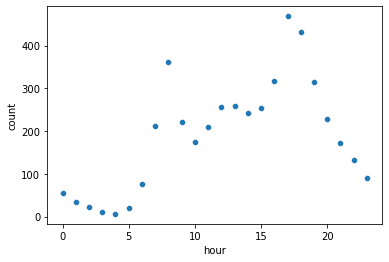

In [59]:
# check the statistsics of the different datasets

#sns.scatterplot(x = hour.index, y =hour['countLog'])
sns.scatterplot(x = hour.index, y =hour['count'])

- - $\color{green}{\text{Fit a Poly Regression model }}$

In [60]:
from sklearn.linear_model import Lasso 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

In [61]:
#Determine the X and y
X = pd.DataFrame(hour.index)
y = hour['count']

In [62]:
# Fit the data with a ppolynomial to see the time evolution
def fit_with_poly(X, y, deg):
    poly = PolynomialFeatures(degree=deg,include_bias= True, interaction_only=False)
    X_poly = poly.fit_transform(X)
    lr = LinearRegression()
    lr.fit(X_poly,y)
    y_pred_poly = lr.predict(X_poly)
    return y_pred_poly, X_poly


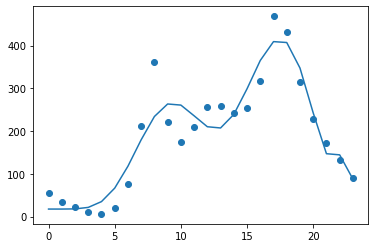

In [63]:
y_pred_poly, X_poly = fit_with_poly(X,y,14)
plt.scatter(X,y)
plt.plot(X,y_pred_poly)


- - $\color{green}{\text{Regularization }}$

In [64]:
def lasso_regularization(X,y):
    lasso = Lasso(alpha = 0.1,max_iter = 1000)
    lasso.fit(X, y)
    y_lasso = lasso.predict(X)
    print(lasso.coef_)
    return y_lasso

[ 0.00000000e+00  1.19727858e+01  6.44056797e-01  3.12202053e-03
  9.81266592e-04  5.90632204e-06 -1.78172863e-06 -1.26285768e-07
 -5.64176312e-09 -1.91701008e-10 -4.65149792e-12 -2.48731707e-14
  6.24408968e-15  5.47046079e-16  3.34429215e-17]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.238e+04, tolerance: 4.084e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


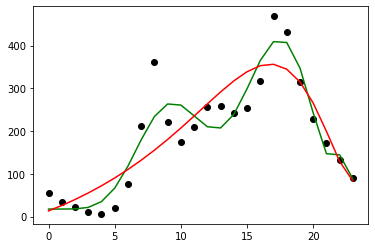

In [65]:
y_lasso = lasso_regularization(X_poly,y)
plt.scatter(X, y, label='actual',color='black')
plt.plot(X, y_pred_poly, label='poly',color = 'green')
plt.plot(X, y_lasso, label='lasso',color = 'red')


- - $\color{green}{\text{GridSearchCV}}$


In [66]:
def optimGScv(X,y,a,b):
    my_pipe = Pipeline([
        ['my_poly_engineering', PolynomialFeatures(degree=4)],
        ['my_lasso', Lasso(max_iter=5000)]
    ])
    my_pipe.fit(X, y)
    parameter_grid = {
        'my_poly_engineering__degree': np.arange(a,b).tolist(),
        'my_lasso__alpha': [0.001, 0.01, 0.1 ]
    }
    gridsearch = GridSearchCV(my_pipe, 
                          parameter_grid, 
                          scoring=None,
                          verbose=1)
    gridsearch.fit(X,y)
    bp = gridsearch.best_params_
    score = gridsearch.best_estimator_.score(X,y)

    y_pred_est = gridsearch.best_estimator_.predict(X)

    return y_pred_est, score, bp

In [67]:
y_pred_est , score_GSCV, best_parameter = optimGScv(X,y,2,5)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.519e+04, tolerance: 4.084e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.204e+04, tolerance: 2.355e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasin

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.175e+04, tolerance: 2.355e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.122e+04, tolerance: 3.348e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasin

- - $\color{green}{\text{Regularization }}$

Score : 0.7334268232972745 {'my_lasso__alpha': 0.1, 'my_poly_engineering__degree': 3}


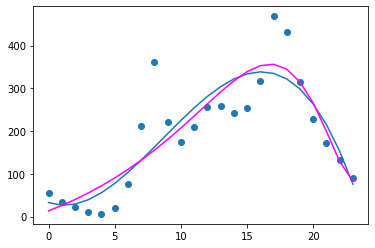

In [68]:
plt.scatter(X,y, )
plt.plot(X,y_pred_est, )
plt.plot(X, y_lasso,color='magenta')
print('Score :',score_GSCV, best_parameter)

- - $\color{red}{\text{See result as a function of days or months}}$

In [70]:
hourDay =bikes.groupby(['hour','day']).mean()
hourDay.head(1)

,,season,holiday,workingday,weather,atemp,humidity,windspeed,count,month,countLog
hour,day,,,,,,,,,,
0,1,2.5,0.0,0.666667,1.291667,22.726875,69.208333,10.167529,55.875,6.5,1.584912


<AxesSubplot:xlabel='hour'>

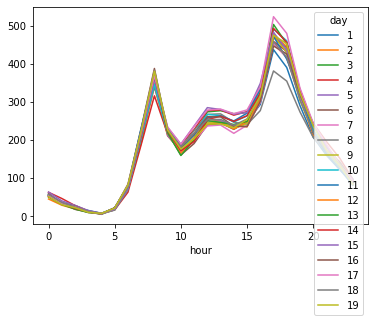

In [72]:
hourDay['count'].unstack(level=1).plot.line()

# 2. Results
- for hours a polynomial of 13 degree could work but it probably overfits
- a polynomial of 3 degree is the best result